Reference：https://blog.csdn.net/u013733326/article/details/79702148
## 开始之前
* 构建具有单隐藏层的2类分类神经网络。
* 使用具有非线性激活功能激活函数，例如tanh。
* 计算交叉熵损失（损失函数）。
* 实现向前和向后传播。

## 准备软件包
* numpy：是用Python进行科学计算的基本软件包。
* sklearn：为数据挖掘和数据分析提供的简单高效的工具。
* matplotlib ：是一个用于在Python中绘制图表的库。
* testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。
* planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

# %matplotlib inline #如果你使用用的是Jupyter Notebook的话请取消注释。把每一次执行的结果显示出来

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。


## 加载和查看数据集
*  X：一个numpy的矩阵，包含了这些数据点的数值
*  Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）

X的维度:(2, 400)


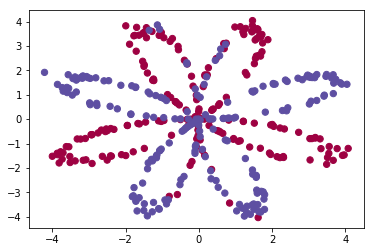

In [33]:
X, Y = load_planar_dataset()
# X：一个numpy的矩阵，包含了这些数据点的数值
# Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）

print("X的维度:" + str(X.shape))
# print("X =:" + str(X))
# print( "Y :" + str(Y))
# plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图

# 上一语句如出现问题，请使用下面的语句：
# print("np.sequence : " + str(np.squeeze(Y))) # 一个[[]] or []
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral) #绘制散点图
# 数据看起来像一朵红色（y = 0）和一些蓝色（y = 1）的数据点的花朵的图案

In [39]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1] # 训练集数量

print("X的维度为：" + str(shape_X))
print("Y的维度为：" + str(shape_Y))
print("数据集里面的数据有：" + str(m) + "个")

X的维度为：(2, 400)
Y的维度为：(1, 400)
数据集里面的数据有：400个


## 查看简单的Logistic回归的分类效果
  在构建完整的神经网络之前，先让我们看看逻辑回归在这个问题上的表现如何，我们可以使用sklearn的内置函数来做到这一点， 运行下面的代码来训练数据集上的逻辑回归分类器。

In [40]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)


c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 400, 'y' with size 400.

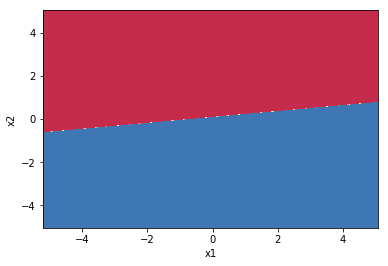

In [48]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
		np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")
# 准确性只有47%的原因是数据集不是线性可分的，所以逻辑回归表现不佳，现在我们正式开始构建神经网络。

准确性只有47%的原因是数据集不是线性可分的，所以逻辑回归表现不佳，现在我们正式开始构建神经网络。

## 搭建神经网络
## 4 - Neural Network model


*模型如图**:
<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

给出所有示例的预测结果，可以按如下方式计算成本$J$:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

构建神经网络的一般方法是：

1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。
2. 初始化模型的参数
3. 循环：
    * 实施前向传播
    * 计算损失
    * 实现向后传播
    * 更新参数（梯度下降）

我们要它们合并到一个nn_model() 函数中，当我们构建好了nn_model（）并学习了正确的参数，我们就可以预测新的数据。


## 定义神经网络
在构建之前，我们要先把神经网络的结构给定义好：

* n_x: 输入层的数量
* n_h: 隐藏层的数量（这里设置为4）
* n_y: 输出层的数量


In [50]:
def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）
    
    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层
    
    return (n_x, n_h, n_y)


In [54]:
#测试layer_sizes
print("=========================测试layer_sizes=========================")
X_asses , Y_asses = layer_sizes_test_case()
print(X_asses.shape)
(n_x,n_h,n_y) =  layer_sizes(X_asses,Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

=========================测试layer_sizes=========================
(5, 3)
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


## 初始化模型的参数
在这里，我们要实现函数initialize_parameters()。我们要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。
我们将会用随机值初始化权重矩阵。

* `np.random.randn(a，b)* 0.01`来随机初始化一个维度为(a，b)的矩阵。
将偏向量初始化为零。

* `np.zeros((a，b))`用零初始化矩阵`（a，b）`。


In [55]:
def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros(shape = (n_h, 1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))
    
    parameters = {"W1" : W1,
	              "b1" : b1,
	              "W2" : W2,
	              "b2" : b2 }
    
    return parameters


In [56]:
#测试initialize_parameters
print("=========================测试initialize_parameters=========================")    
n_x , n_h , n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x , n_h , n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试initialize_parameters=========================
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


循环
前向传播
我们现在要实现前向传播函数forward_propagation()。
我们可以使用sigmoid()函数，也可以使用np.tanh()函数。
步骤如下：

* 使用字典类型的parameters（它是initialize_parameters() 的输出）检索每个参数。
* 实现向前传播, 计算$Z^{[1]},A^{[1]},Z^{[2]},Z^{[1]}$和 $[2]A^{[2]}A [2]$
 （ 训练集里面所有例子的预测向量）。
* 反向传播所需的值存储在“cache”中，cache将作为反向传播函数的输入。


In [61]:
def forward_propagation( X , parameters ):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return (A2, cache)


In [62]:
#测试forward_propagation
print("=========================测试forward_propagation=========================") 
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))


=========================测试forward_propagation=========================
-0.0004997557777419913 -0.0004969633532317802 0.0004381874509591466 0.500109546852431


现在我们已经计算了$A^{[2]},a^{[2](i)}$
 包含了训练集里每个数值，现在我们就可以构建成本函数了。


## 计算损失
计算成本的公式如下：

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

有很多的方法都可以计算交叉熵损失，比如下面的这个公式，我们在python中可以这么实现：
KaTeX parse error: \tag works only in display equations:
```
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # 不需要使用循环就可以直接算出来。
```

当然，你也可以使用np.multiply（）然后使用np.sum（）或者直接使用np.dot（）

In [64]:
def compute_cost(A2,Y,parameters):
    """
    计算方程（6）中给出的交叉熵成本，
    
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本 - 交叉熵成本给出方程（13）
    """
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    
    return cost


In [65]:
#测试compute_cost
print("=========================测试compute_cost=========================") 
A2 , Y_assess , parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2,Y_assess,parameters)))

=========================测试compute_cost=========================
cost = 0.6929198937761266


使用正向传播期间计算的cache，现在可以利用它实现反向传播。

现在我们要开始实现函数backward_propagation（）。

向后传播
  说明：反向传播通常是深度学习中最难（数学意义）部分，为了帮助你，这里有反向传播讲座的幻灯片， 由于我们正在构建向量化实现，因此我们将需要使用这下面的六个方程：
  
<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/grad_summary.png" style="width:600px;height:300px;">
  
  <!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - 为了计算 dZ1需要计算 $g^{[1]'}(Z^{[1]})$. 其中 $g^{[1]}(.)$ 是tanh激活函数， 如果 $a = g^{[1]}(z)$ 则 $g^{[1]'}(z) = 1-a^2$. 所以，我们需要使用 
    `(1 - np.power(A1, 2))`来计算$g^{[1]'}(Z^{[1]})$。
    

In [66]:
def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。
    
    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    
    return grads


In [67]:
#测试backward_propagation
print("=========================测试backward_propagation=========================")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

=========================测试backward_propagation=========================
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


## 更新参数
我们需要使用(dW1, db1, dW2, db2)来更新(W1, b1, W2, b2)。
更新算法如下：
$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$

* $\alpha$：学习速率
* $\theta$ ：参数
我们需要选择一个良好的学习速率，我们可以看一下下面这两个图(由Adam Harley提供)：
<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/sgd.gif" style="width:400;height:400;">

<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%203/Planar%20data%20classification%20with%20one%20hidden%20layer/images/sgd_bad.gif" style="width:400;height:400;">

上面两个图分别代表了具有良好学习速率（收敛）和不良学习速率（发散）的梯度下降算法。


In [68]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数
    
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]
    
    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [70]:
#测试update_parameters
print("=========================测试update_parameters=========================")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试update_parameters=========================
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


## 整合
我们现在把上面的东西整合到nn_model()中，神经网络模型必须以正确的顺序使用先前的功能

In [71]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
     
    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
    return parameters


In [73]:
#测试nn_model
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试nn_model=========================


c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


W1 = [[-3.89167767  4.77541602]
 [-6.77960338  1.20272585]
 [-3.88338966  4.78028666]
 [ 6.77958203 -1.20272574]]
b1 = [[ 2.11530892]
 [ 3.41221357]
 [ 2.11585732]
 [-3.41221322]]
W2 = [[-2512.9093032  -2502.70799785 -2512.01655969  2502.65264416]]
b2 = [[-22.29071761]]


## 预测
构建predict()来使用模型进行预测， 使用向前传播来预测结果。

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [74]:
def predict(parameters,X):
    """
    使用学习的参数，为X中的每个示例预测一个类
    
    参数：
		parameters - 包含参数的字典类型的变量。
	    X - 输入数据（n_x，m）
    
    返回
		predictions - 我们模型预测的向量（红色：0 /蓝色：1）
     
     """
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions


In [75]:
#测试predict
print("=========================测试predict=========================")

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))


=========================测试predict=========================
预测的平均值 = 0.6666666666666666


现在我们把所有的东西基本都做完了，我们开始正式运行。

## 正式运行

第  0  次循环，成本为：0.6929929838297801
第  1000  次循环，成本为：0.2836648904015071
第  2000  次循环，成本为：0.2825159788696731
第  3000  次循环，成本为：0.28093319977414316
第  4000  次循环，成本为：0.27645053549448817
第  5000  次循环，成本为：0.22574488024454817
第  6000  次循环，成本为：0.08816973883525916
第  7000  次循环，成本为：0.06959702650965269
第  8000  次循环，成本为：0.06544384837705826
第  9000  次循环，成本为：0.06343730175410027
准确率: 97%


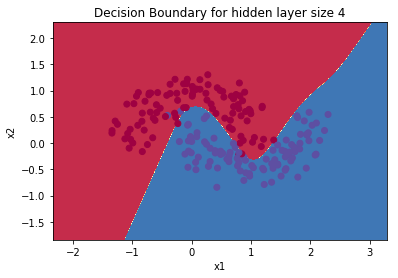

In [80]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

#绘制边界
# plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y) 修改
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

## 更改隐藏层节点数量
我们上面的实验把隐藏层定为4个节点，现在我们更改隐藏层里面的节点数量，看一看节点数量是否会对结果造成影响。

隐藏层的节点数量： 1  ，准确率: 88.5 %
隐藏层的节点数量： 2  ，准确率: 89.5 %
隐藏层的节点数量： 3  ，准确率: 87.5 %
隐藏层的节点数量： 4  ，准确率: 90.5 %
隐藏层的节点数量： 5  ，准确率: 89.0 %
隐藏层的节点数量： 20  ，准确率: 89.5 %
隐藏层的节点数量： 50  ，准确率: 89.0 %


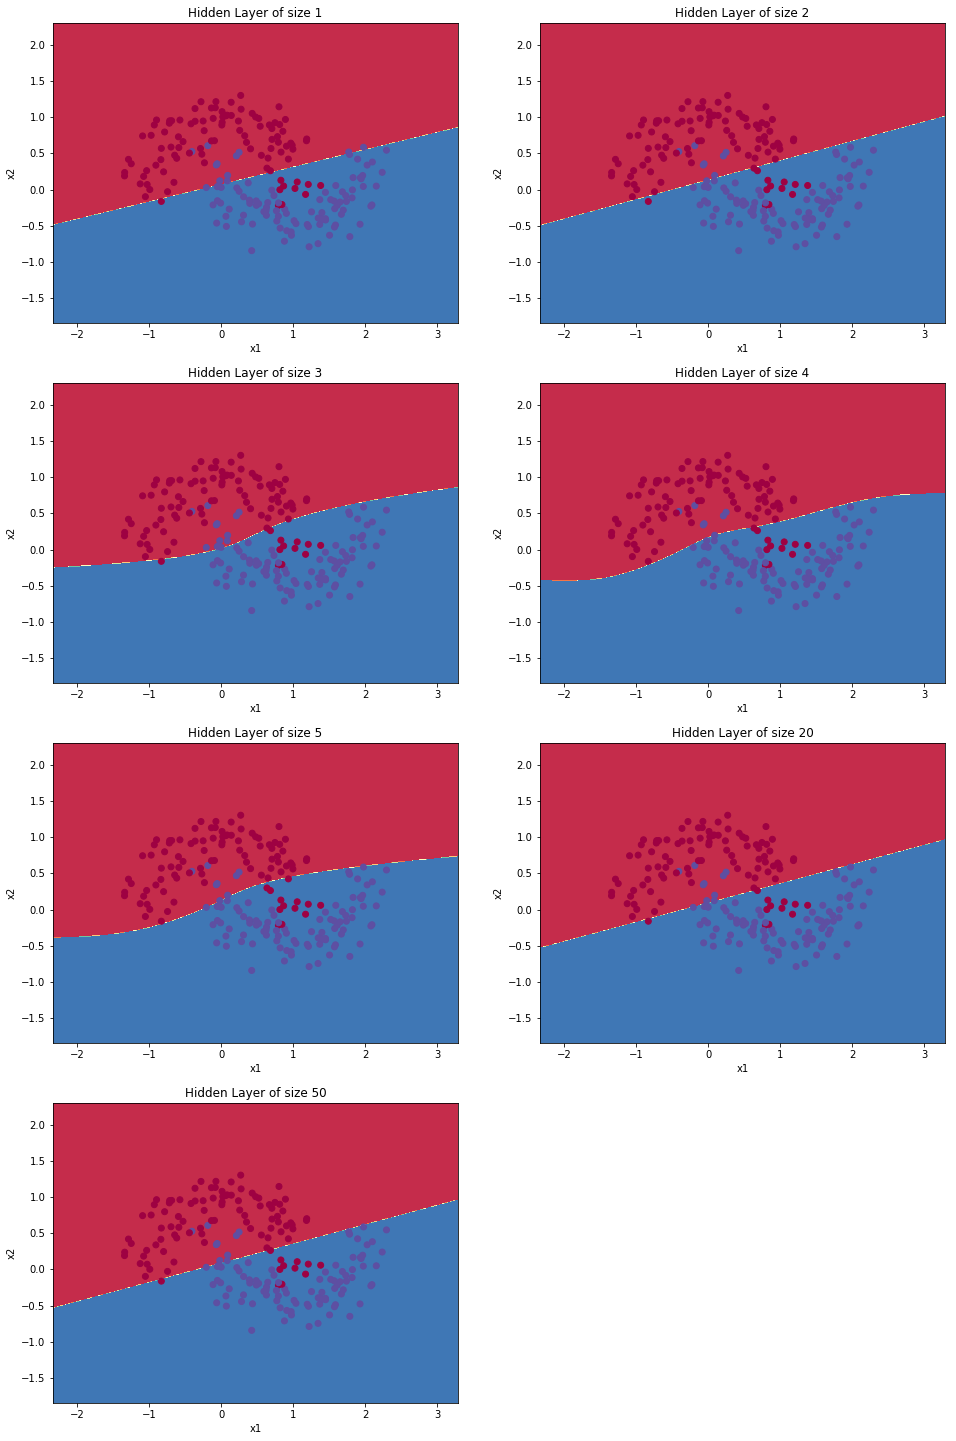

In [81]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))


较大的模型（具有更多隐藏单元）能够更好地适应训练集，直到最终的最大模型过度拟合数据。
最好的隐藏层大小似乎在n_h = 5附近。实际上，这里的值似乎很适合数据，而且不会引起过度拟合。
我们还将在后面学习有关正则化的知识，它允许我们使用非常大的模型（如n_h = 50），而不会出现太多过度拟合。

## 【可选】探索

* 当改变sigmoid激活或ReLU激活的tanh激活时会发生什么？
* 改变learning_rate的数值会发生什么
* 如果我们改变数据集呢？

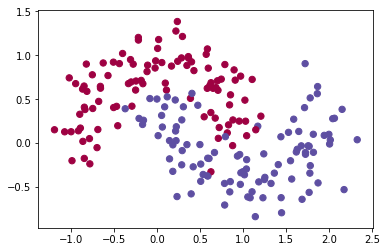

In [85]:
# 数据集
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

if dataset == "blobs":
    Y = Y % 2

# plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

#上一语句如出现问题请使用下面的语句：
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)
